In [1]:
import time
import numpy as np
import pandas as pd
from gmm import GMM
import matplotlib.pyplot as plt
from multiprocessing import Pool
from collections import defaultdict
from scipy.stats import multivariate_normal as mvn

plt.rcParams["font.size"] = 18
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = 8,6
plt.rcParams['font.serif'] = "Cambria"
plt.rcParams['font.family'] = "serif"

%load_ext autoreload
%autoreload 2

In [2]:
df = pd.read_csv("../datasets/1B/train.csv", header=None)
X = df.drop(2, axis=1).to_numpy()
df.head()

,0,1,2
0,0.537115,0.452538,0.0
1,0.380729,0.371252,0.0
2,0.551707,0.496879,0.0
3,0.128153,0.337706,0.0
4,-0.893600,-2.493547,0.0


In [3]:
classes = np.unique(df[2])
gmm_list = defaultdict(list)
q_list = list(range(2,10))  

for i in classes:
    df_select = df[df[2]==i]
    X_select = df_select.drop(2, axis=1).to_numpy()
    for q in q_list:
        gmm = GMM(q=q)
        gmm.fit(X_select)
        gmm_list[i].append(gmm)

 82%|████████▏ | 82/100 [00:27<00:05,  3.02it/s]


In [4]:
import pickle
fin = open("1b_gmm_results", "wb")
pickle.dump(gmm_list, fin)
fin.close()

In [5]:
df_test = pd.read_csv("../datasets/1B/dev.csv", header=None)
X_test = df_test.drop(2, axis=1).to_numpy()
X = df.drop(2, axis=1).to_numpy()
df_test.head()

,0,1,2
0,0.438052,-2.337230,0.0
1,1.229295,0.295078,0.0
2,1.586945,-0.242402,0.0
3,-1.047739,-2.606678,0.0
4,0.993552,0.350345,0.0


In [6]:
accuracy_list = []
test_accuracy_list = []
for i in range(len(q_list)):
    gmm0 = gmm_list[0.0][i]
    gmm1 = gmm_list[1.0][i]
    gmm2 = gmm_list[2.0][i]
    
    # Training
    a = gmm0.indv_log_likelihood(X)
    b = gmm1.indv_log_likelihood(X)
    c = gmm2.indv_log_likelihood(X)

    d = np.hstack((a, b, c))
    pred = np.argmax(d, axis=1)
    accuracy_list.append(np.sum(pred == df[2])/df[2].size)
    
    # Testing
    a = gmm0.indv_log_likelihood(X_test)
    b = gmm1.indv_log_likelihood(X_test)
    c = gmm2.indv_log_likelihood(X_test)

    d = np.hstack((a, b, c))
    pred = np.argmax(d, axis=1)
    test_accuracy_list.append(np.sum(pred == df_test[2])/df_test[2].size)

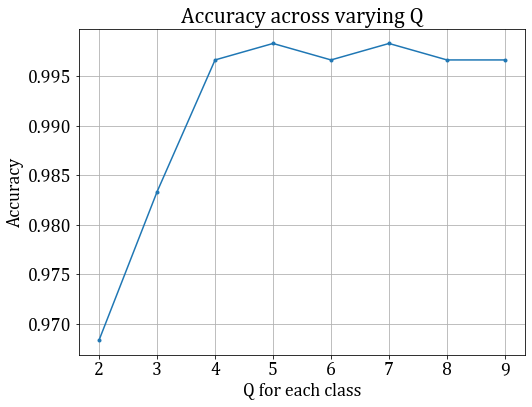

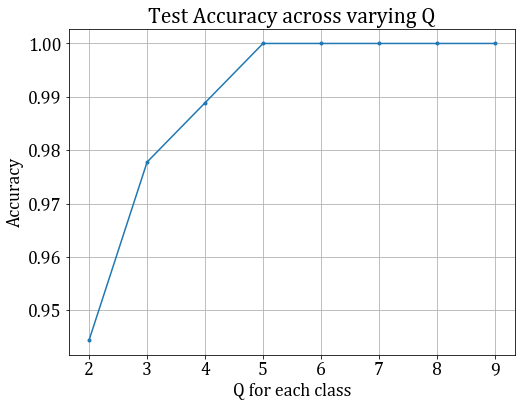

In [8]:
plt.plot(q_list, accuracy_list, '.-')
plt.title("Accuracy across varying Q")
plt.xlabel("Q for each class")
plt.ylabel("Accuracy")
plt.show()

plt.plot(q_list, test_accuracy_list, '.-')
plt.title("Test Accuracy across varying Q")
plt.xlabel("Q for each class")
plt.ylabel("Accuracy")
plt.show()